In [1]:
## import necessary modules

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns

sns.set_style('darkgrid')

In [2]:
#import csv file

df=pd.read_csv('Churn_Modelling.csv')
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [3]:
#No. of rows and columns

df.shape

(10000, 14)

In [4]:
# drop unnecessary feature

df=df.drop(['RowNumber','CustomerId','Surname'],axis=1)

In [5]:
df.shape

(10000, 11)

In [6]:
df.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [7]:
#Create dummy variables

geography=pd.get_dummies(df["Geography"],drop_first=True)
gender=pd.get_dummies(df['Gender'],drop_first=True)

In [8]:
# Concatenate the Data Frames

df=pd.concat([df,geography,gender],axis=1)

# Drop Unnecessary columns
df=df.drop(['Geography','Gender'],axis=1)

In [9]:
df.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Germany,Spain,Male
0,619,42,2,0.00,1,1,1,101348.88,1,0,0,0
1,608,41,1,83807.86,1,0,1,112542.58,0,0,1,0
2,502,42,8,159660.80,3,1,0,113931.57,1,0,0,0
3,699,39,1,0.00,2,0,0,93826.63,0,0,0,0
4,850,43,2,125510.82,1,1,1,79084.10,0,0,1,0


In [10]:
df['Exited'].value_counts()

0    7963
1    2037
Name: Exited, dtype: int64

In [11]:
# Dividing dependent and independent variables

X=df.drop('Exited',axis=1)
y=df['Exited']


In [12]:
# Sampling

from imblearn.over_sampling import SMOTE 
from collections import Counter

sampler = SMOTE()
X_res, y_res = sampler.fit_resample(X, y)

print('SMOTE {}'.format(Counter(y_res)))

SMOTE Counter({1: 7963, 0: 7963})


In [13]:
# Splitting a dataset

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test= train_test_split(X_res, y_res, test_size=0.25, random_state=42)

In [14]:
# Feature Scaling

from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [15]:
# import modules to create model

from keras.models import Sequential
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV

from keras.layers import Dense, Activation,  Dropout
from keras.activations import relu, sigmoid

In [16]:
#Build Model

def build_model(layers, activation):
    model = Sequential()
    for i, nodes in enumerate(layers):
        if i==0:
            model.add(Dense(nodes,input_dim=X_train.shape[1]))
            model.add(Activation(activation))
            
        else:
            model.add(Dense(nodes))
            model.add(Activation(activation))
            
    model.add(Dense(1)) 
    
    model.compile(optimizer='adam', loss='binary_crossentropy',metrics=['accuracy'])
    return model
    
model = KerasClassifier(build_fn=build_model, verbose=0)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead.


In [17]:
#putting Parameters

layers = [(40, 20), (45, 30, 15), (60,40,25,10),(80,60,40,25,10)]
activations = ['sigmoid', 'relu']
param_grid = dict(layers=layers, activation=activations, batch_size = [128, 256], epochs=[30])
grid = GridSearchCV(estimator=model, param_grid=param_grid,cv=5)

In [18]:
#fit train data
grid_result = grid.fit(X_train, y_train)


In [19]:
grid_result

GridSearchCV(cv=5,
             estimator=<keras.wrappers.scikit_learn.KerasClassifier object at 0x7fec24eb5b90>,
             param_grid={'activation': ['sigmoid', 'relu'],
                         'batch_size': [128, 256], 'epochs': [30],
                         'layers': [(40, 20), (45, 30, 15), (60, 40, 25, 10),
                                    (80, 60, 40, 25, 10)]})

In [20]:
[grid_result.best_score_,grid_result.best_params_]

[0.8219191431999207,
 {'activation': 'relu',
  'batch_size': 128,
  'epochs': 30,
  'layers': (60, 40, 25, 10)}]

In [21]:
y_pred=grid.predict(X_test)

In [22]:
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score,confusion_matrix

score=accuracy_score(y_test,y_pred) #Accuracy = TP+TN/TP+FP+FN+TN
score=score*100

print('Accuracy of the model is {0:.2f}%'.format(score))


Accuracy of the model is 82.82%


In [23]:
p_score=precision_score(y_test,y_pred)  #Precision = TP/TP+FP
re_score=recall_score(y_test,y_pred)    #Recall = TP/TP+FN
f_score=f1_score(y_test,y_pred)         #F1 Score = 2*(Recall * Precision) / (Recall + Precision)

print(f'precision score of the model is {p_score}')
print(f'recall score of the model is {re_score}')
print(f'f1_score of the model is {f_score}')

precision score of the model is 0.8225971370143149
recall score of the model is 0.8268242548818089
f1_score of the model is 0.8247052793439262


In [24]:
confusion_m=confusion_matrix(y_test,y_pred )
confusion_m

array([[1689,  347],
       [ 337, 1609]])

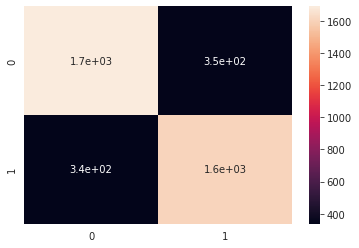

In [25]:
sns.heatmap(confusion_m, annot=True)